# Personal Information
Name: **Victor Brouwer**

StudentID: **15752739**

Email: [**victor.brouwer@student.uva.nl**](victor.brouwer@student.uva.nl)

Submitted on: **23.03.2025**

Github: [**https://github.com/VictorBrouwer/DS_Thesis**](https://github.com/VictorBrouwer/DS_Thesis)

# Data Context

The **Permutation Flow Shop Problem (PFSP)** involves scheduling a set of jobs \( N = \{1, \dots, n\} \) on a set of machines \( M = \{1, \dots, m\} \). Each job \( j \) requires a processing time \( p_{ij} \) on machine \( i \), and all jobs must follow the same sequence across machines, starting from machine 1 and ending at machine \( m \). The objective is to determine the optimal job permutation that minimizes the maximum completion time, also known as the *makespan*.

To analyze and benchmark scheduling algorithms, I will use the **Taillard dataset**, a widely recognized benchmark introduced by E. Taillard in 1993. This dataset contains 120 problem instances of varying sizes, representing realistic manufacturing and production scheduling scenarios. It has been extensively used in academic research for evaluating heuristics and metaheuristics in PFSP optimization.

For this exploratory data analysis (EDA), I will focus on the `tai_50_20_8` instance, which consists of **50 jobs and 20 machines**. The Taillard dataset facilitates consistent performance comparisons across scheduling methods, making it an ideal choice for this study. The dataset is publicly available [here](http://mistic.heig-vd.ch/taillard/problemes.dir/ordonnancement.dir/ordonnancement.html).


# Data Description

The Taillard dataset for the PFSP is structured as follows:

* Header: Contains metadata like the number of jobs, machines, and the best known solution.
* Data Lines: Subsequent lines provide processing times, with each row representing a machine and each column a job.

Essentially, the dataset provides the necessary information to schedule jobs across machines, including a benchmark for solution evaluation.

Because the data is synthetically generated, only a brief exploratory data analysis (EDA) on the statistics will be conducted, as there is no need for data cleaning. Instead, this notebook will focus on obtaining a solution to the PFSP using the Adaptive Large Neighborhood Search (ALNS) framework. Additionally, it will address a subquestion of my research: Can GenAI generate diverse and effective destroy and repair operators tailored to specific problem instances? To explore this, two operators (one repair and one destroy) generated by ChatGPT-4o mini will be included in the framework, and their performance will be evaluated.

In [10]:
!pip install ALNS

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [11]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt


from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

### Data Loading

Number of jobs: 50, Number of machines: 20
Best known value: 3715
Processing times shape: (20, 50)
Processing times summary statistics:
Mean: 49.271
Standard Deviation: 28.508026220697918
Min: 1
Max: 99


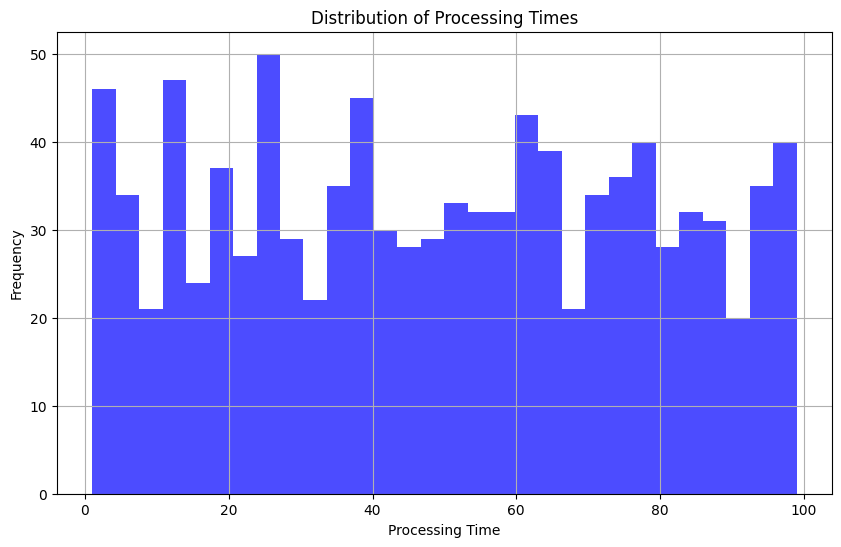

In [12]:
 ### EDA: Initial Data Analysis
# Load the data from the file and perform initial exploratory data analysis
data_path = "data/tai50_20_02.txt"
with open(data_path, "r") as fi:
    lines = fi.readlines()

# Extracting the number of jobs, machines, and best known value
n_jobs, n_machines, _, bkv, _ = [int(num) for num in lines[1].split()]
processing_times = np.genfromtxt(lines[3:], dtype=int)

# Displaying the shape of the data
print(f"Number of jobs: {n_jobs}, Number of machines: {n_machines}")
print(f"Best known value: {bkv}")
print("Processing times shape:", processing_times.shape)

# Displaying summary statistics
print("Processing times summary statistics:")
print(f"Mean: {np.mean(processing_times)}")
print(f"Standard Deviation: {np.std(processing_times)}")
print(f"Min: {np.min(processing_times)}")
print(f"Max: {np.max(processing_times)}")

# Visualizing the distribution of processing times
plt.figure(figsize=(10, 6))
plt.hist(processing_times.flatten(), bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Processing Times")
plt.xlabel("Processing Time")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## Data Class Definition
A Data class is defined to encapsulate the number of jobs, machines, best known value, and processing times. It includes a method to load data from a file.

In [13]:
SEED = 2345
@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int  # best known value
    processing_times: np.ndarray

    @classmethod
    def from_file(cls, path):
        with open(path, "r") as fi:
            lines = fi.readlines()

            n_jobs, n_machines, _, bkv, _ = [
                int(num) for num in lines[1].split()
            ]
            processing_times = np.genfromtxt(lines[3:], dtype=int)

            return cls(n_jobs, n_machines, bkv, processing_times)


DATA = Data.from_file("data/tai50_20_02.txt")



## Completion Time and Makespan Calculation
Functions are defined to compute the completion times for a given job schedule and to calculate the makespan, which is the maximum completion time across all jobs.

In [14]:

def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(DATA.processing_times.shape, dtype=int)

    for idx, job in enumerate(schedule):
        for machine in range(DATA.n_machines):
            prev_job = completion[machine, schedule[idx - 1]] if idx > 0 else 0
            prev_machine = completion[machine - 1, job] if machine > 0 else 0
            processing = DATA.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]

## Gantt Chart Visualization
A function `plot` is implemented to visualize the job schedule as a Gantt chart, showing the completion times for each job on each machine.

In [15]:
def plot(schedule, name):
    """
    Plots a Gantt chart of the schedule for the permutation flow shop problem.
    """
    n_machines, n_jobs = DATA.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - DATA.processing_times

    # Plot each job using its start and completion time
    cmap = plt.colormaps["rainbow"].resampled(n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, DATA.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"{name}\n Makespan: {compute_makespan(schedule)}")
    ax.set_ylabel(f"Machine")
    ax.set_xlabel(f"Completion time")
    ax.set_yticks(range(DATA.n_machines))
    ax.set_yticklabels(range(1, DATA.n_machines + 1))
    ax.invert_yaxis()

    plt.show()

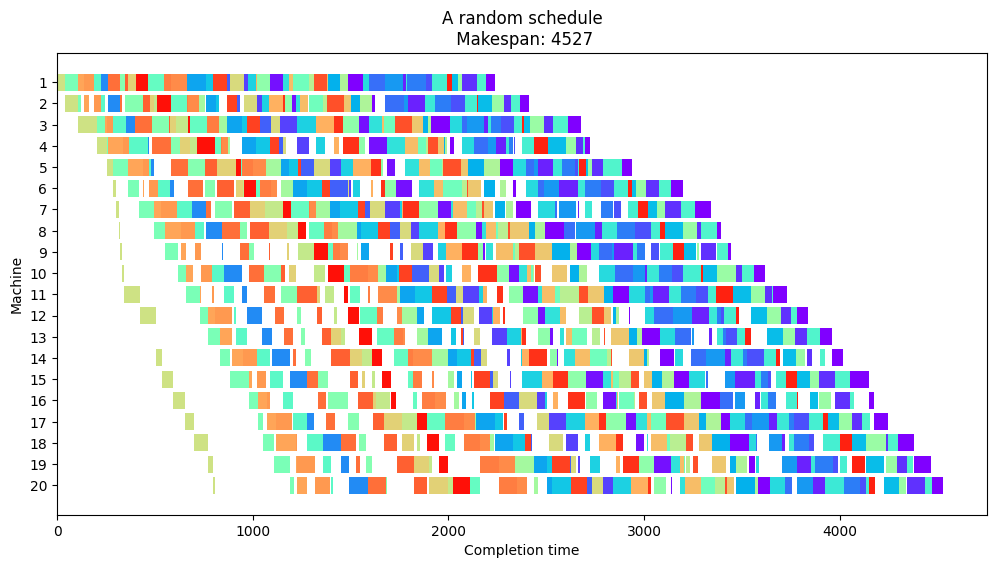

In [16]:
plot(
    rnd.choice(range(DATA.n_jobs), size=DATA.n_jobs, replace=False),
    "A random schedule",
)

## Solution Class
A `Solution` class is created to represent a job schedule, allowing for operations such as calculating the objective (makespan), inserting jobs, and optimizing job placement.

In [17]:
class Solution:
    def __init__(
        self, schedule: List[int], unassigned: Optional[List[int]] = None
    ):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)

## Insertion Cost Calculation
The function `all_insert_cost` computes the makespan for all possible insertion positions of a job in the schedule.

In [18]:
def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:

    k = len(schedule) + 1
    m = DATA.processing_times.shape[0]
    p = DATA.processing_times

    # Earliest completion of schedule[j] on machine i before insertion
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]

## Destruction and Repair Operators
Functions are defined for various destruction and repair strategies:
- **Random Removal**: Randomly removes jobs from the schedule.
- **Adjacent Removal**: Removes adjacent jobs from the schedule.
- **Greedy Repair**: Inserts unassigned jobs back into the schedule based on their processing times.

In [19]:
def random_removal(state: Solution, rng, n_remove=2) -> Solution:
    destroyed = deepcopy(state)

    for job in rng.choice(DATA.n_jobs, n_remove, replace=False):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed

In [20]:
def adjacent_removal(state: Solution, rng, n_remove=2) -> Solution:
    destroyed = deepcopy(state)

    start = rng.integers(DATA.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed

In [21]:
def greedy_repair(state: Solution, rng, **kwargs) -> Solution:
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state

## NEH Heuristic
The NEH (Nawaz-Enscore-Ham) heuristic is implemented to create an initial solution by scheduling jobs in decreasing order of their total processing times.

In [22]:
def NEH(processing_times: np.ndarray) -> Solution:
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution

In [23]:
init = NEH(DATA.processing_times)
objective = init.objective()
pct_diff = 100 * (objective - DATA.bkv) / DATA.bkv

print(f"Initial solution objective is {objective}.")
print(f"This is {pct_diff:.1f}% worse than the best known value {DATA.bkv}.")

Initial solution objective is 3937.
This is 6.0% worse than the best known value 3715.


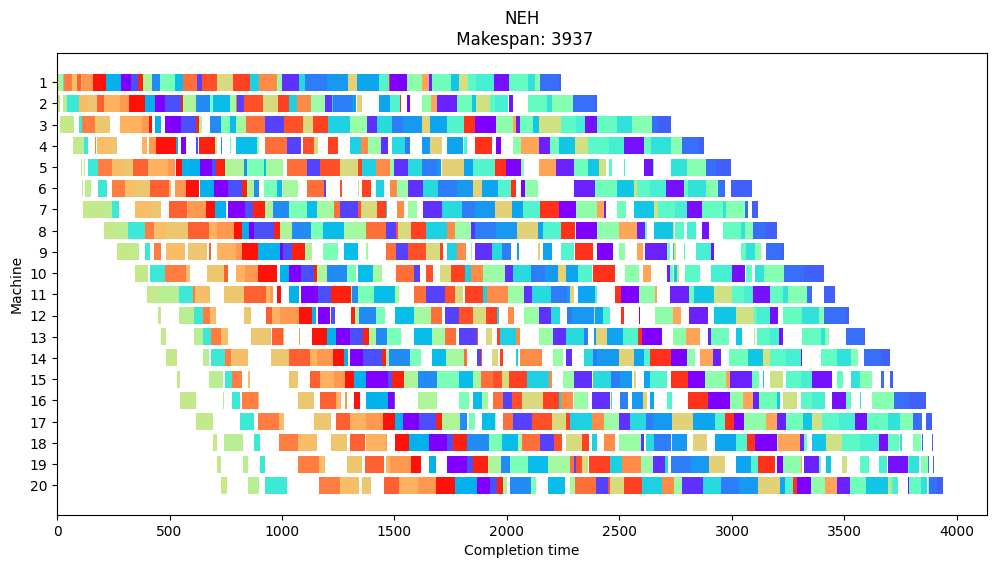

In [24]:
plot(init.schedule, "NEH")

## AI generated operators
The following operators were generated by ChatGPT:
- get_critical_path: Traces the critical path in the current job schedule.
- critical_destroy: Removes jobs contributing most to the makespan based on the critical path.
- local_search_repair: Reinserts unassigned jobs using a local search for optimal placement.

In [25]:
def get_critical_path(schedule: List[int]) -> List[int]:
    """
    Trace the critical path in the current schedule.
    Starting from the last machine and the last job,
    move backwards by choosing the predecessor that contributed to
    the completion time (using the recurrence in compute_completion_times).

    Returns a list of unique jobs on the critical path.
    """
    comp = compute_completion_times(schedule)
    m = DATA.n_machines
    k = len(schedule)
    
    cp_jobs = set()  # to store jobs on the critical path (unique)
    i = m - 1         # start at the last machine
    j = k - 1         # start at the last job in the schedule
    cp_jobs.add(schedule[j])
    
    # Trace back until we reach the beginning
    while i > 0 or j > 0:
        # if we can move left (i.e. to previous job on the same machine)
        # and either we are at the first machine or the left move explains the completion time,
        # then move left; otherwise, move up (to previous machine)
        if j > 0 and (i == 0 or comp[i, schedule[j]] == comp[i, schedule[j-1]] + DATA.processing_times[i, schedule[j]]):
            j -= 1
        else:
            i -= 1
        cp_jobs.add(schedule[j])
        
    return list(cp_jobs)


def critical_destroy(state: Solution, rng, n_remove: int = 2) -> Solution:
    """
    Destroy operator that removes jobs contributing most to the makespan.
    It identifies jobs on the critical path (via compute_completion_times)
    and then removes the ones with highest processing time on the last (bottleneck) machine.
    If the number of jobs on the critical path is fewer than n_remove,
    additional jobs are removed randomly.
    """
    # Create a deep copy so we don't modify the original solution.
    destroyed = deepcopy(state)
    
    # Identify the jobs on the critical path.
    cp_jobs = get_critical_path(destroyed.schedule)
    
    # If there are enough critical jobs, sort them by processing time on the last machine
    # (i.e., the bottleneck) in descending order.
    if len(cp_jobs) >= n_remove:
        cp_jobs_sorted = sorted(cp_jobs, key=lambda j: DATA.processing_times[DATA.n_machines - 1, j], reverse=True)
        jobs_to_remove = cp_jobs_sorted[:n_remove]
    else:
        # Otherwise, remove all critical path jobs and then select additional jobs at random.
        jobs_to_remove = cp_jobs.copy()
        remaining_jobs = [j for j in destroyed.schedule if j not in jobs_to_remove]
        additional = rng.choice(remaining_jobs, n_remove - len(cp_jobs), replace=False)
        jobs_to_remove.extend(additional)
    
    # Remove the selected jobs from the schedule and add them to the unassigned list.
    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)
    
    return destroyed


def local_search_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Enhanced repair operator that reinserts unassigned jobs using a local search.
    
    Steps:
      1. Identify the bottleneck machine (with highest total processing time).
      2. Sort unassigned jobs in descending order by their processing time on that machine.
      3. For each unassigned job:
         a. Compute all insertion positions (using Taillard's acceleration via all_insert_cost).
         b. Insert the job at the best position.
         c. Perform a local search (by swapping with neighbors) to check for further improvements.
    """
    # Identify the bottleneck machine (machine with maximum total processing time)
    total_pt = np.sum(DATA.processing_times, axis=1)
    bottleneck = int(np.argmax(total_pt))
    
    # Sort unassigned jobs: those with higher processing time on the bottleneck machine get priority.
    state.unassigned.sort(key=lambda j: DATA.processing_times[bottleneck, j], reverse=True)
    
    # Reinsert each unassigned job
    while state.unassigned:
        # Pop the job with highest priority
        job = state.unassigned.pop(0)
        
        # Get the makespan for all possible insertion positions using Taillard's method.
        insertion_options = all_insert_cost(state.schedule, job)
        best_index, best_cost = min(insertion_options, key=lambda x: x[1])
        
        # Insert the job at the best found position.
        state.schedule.insert(best_index, job)
        
        # --- Local Search Phase ---
        # Try to further improve the schedule by swapping the inserted job with its neighbors.
        improved = True
        while improved:
            improved = False
            current_cost = compute_makespan(state.schedule)
            index = state.schedule.index(job)
            
            # Try moving the job one position to the left.
            if index > 0:
                state.schedule[index], state.schedule[index - 1] = state.schedule[index - 1], state.schedule[index]
                new_cost = compute_makespan(state.schedule)
                if new_cost < current_cost:
                    improved = True
                    current_cost = new_cost  # accept the move
                else:
                    # Revert the swap if no improvement
                    state.schedule[index], state.schedule[index - 1] = state.schedule[index - 1], state.schedule[index]
            
            # Try moving the job one position to the right.
            index = state.schedule.index(job)  # update index (in case it changed)
            if index < len(state.schedule) - 1:
                state.schedule[index], state.schedule[index + 1] = state.schedule[index + 1], state.schedule[index]
                new_cost = compute_makespan(state.schedule)
                if new_cost < current_cost:
                    improved = True
                    current_cost = new_cost
                else:
                    # Revert if no improvement
                    state.schedule[index], state.schedule[index + 1] = state.schedule[index + 1], state.schedule[index]
        # --- End Local Search Phase ---
    
    return state


In [26]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(adjacent_removal)
alns.add_destroy_operator(critical_destroy)

alns.add_repair_operator(greedy_repair)
alns.add_repair_operator(local_search_repair)

In [27]:
ITERS = 8000

init = NEH(DATA.processing_times)
select = AlphaUCB(
    scores=[5, 2, 1, 0.5],
    alpha=0.05,
    num_destroy=len(alns.destroy_operators),
    num_repair=len(alns.repair_operators),
)
stop = MaxIterations(ITERS)

In [28]:
accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, ITERS)

In [29]:
result = alns.iterate(init, select, accept, stop)

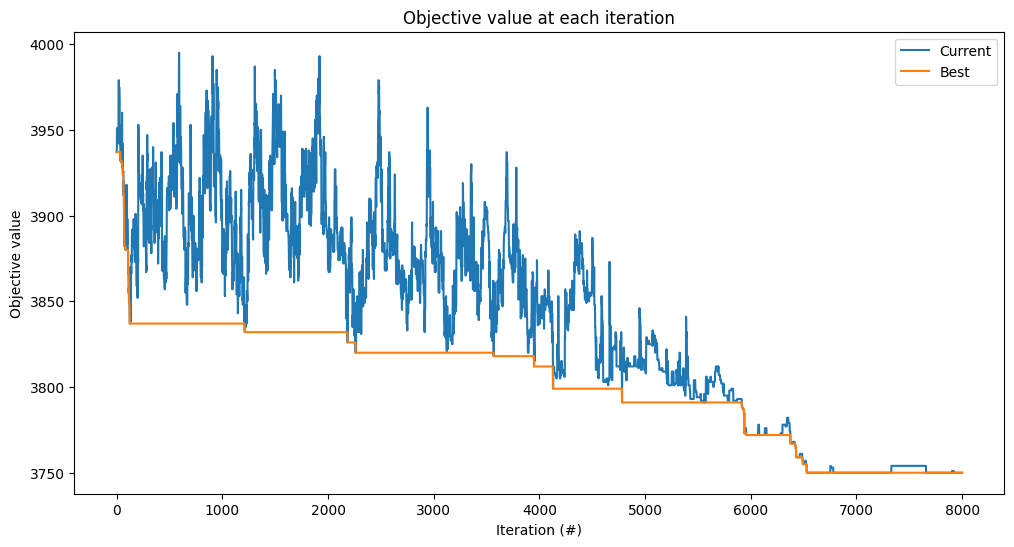

In [30]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [31]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - DATA.bkv) / DATA.bkv

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_diff:.1f}% worse than the best known value {DATA.bkv}.")

Best heuristic objective is 3750.
This is 0.9% worse than the best known value 3715.


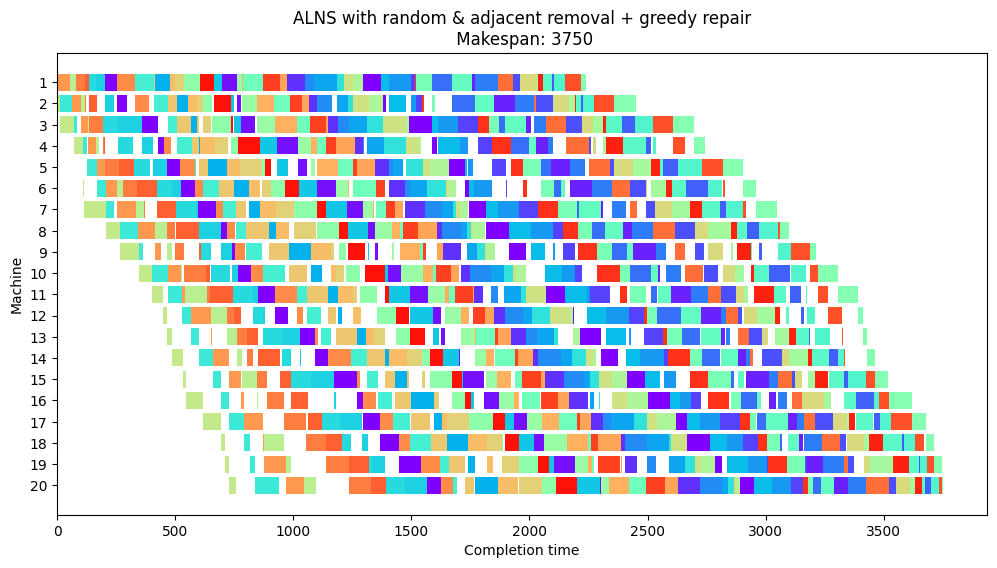

In [32]:
name = "ALNS with random & adjacent removal + greedy repair"
plot(result.best_state.schedule, name)

## Conclusion

In this notebook, we conducted an exploratory data analysis (EDA) on the Permutation Flow Shop Problem (PFSP) using the Taillard dataset, specifically focusing on the `tai_50_20_8` instance. Through the analysis, we successfully loaded the data, computed essential statistics, and visualized the distribution of processing times, providing insights into the characteristics of the dataset.

We implemented a structured approach to solving the PFSP by defining a `Data` class to encapsulate relevant information and a `Solution` class to represent job schedules. The use of the NEH (Nawaz-Enscore-Ham) heuristic allowed us to generate an initial solution based on job processing times, which served as a foundation for further optimization.

The Adaptive Large Neighborhood Search (ALNS) framework was employed to iteratively improve the solution through various destruction and repair strategies. By incorporating both random and greedy approaches, we effectively explored the solution space and identified a schedule that minimized the makespan.

Additionally, we addressed a subquestion of our research: Can GenAI generate diverse and effective destroy and repair operators tailored to specific problem instances? To explore this, we included two operators (one repair and one destroy) generated by ChatGPT-4o mini in the framework, evaluating their performance.

The results demonstrated that the ALNS algorithm with AI-generated operators produced a competitive solution, with the best objective value being only a small percentage worse than the best known value from the dataset. This indicates the effectiveness of the implemented methods in tackling the PFSP.

## References
    
    Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.

    Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.